In [183]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## 1. Data preparation 
Input datat: [Open, Close, Max, Min, Volume]*14 days.

Output: Price of 15th day.

In [225]:
df = pd.read_csv("./600029.SS.csv",parse_dates=["Date"],index_col=[0])[['Open','Close','High','Low','Volume']]
df = df.iloc[::-1]
# Split test and train
ntest = round(len(df)*0.10)  # 20% are test set
df_for_training=df[:-ntest]
df_for_testing=df[-ntest:]

print(df_for_training.shape,'(number of data for training, dim)')
print(df_for_testing.shape,'(number of data for test, dim)')

(1247, 5) (number of data for training, dim)
(138, 5) (number of data for test, dim)


In [226]:
# Scale the data by using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [227]:
# Use previous 30 days data to predict 31st day open price
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,14)
testX,testY=createXY(df_for_testing_scaled,14)

In [207]:
# Define a function to create the LSTM model
from tensorflow.keras.optimizers import SGD

def create_lstm_model(units=50, optimizer=opt.SGD(learning_rate=0.1, momentum=0.9)):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(14, 5)))
    #model.add(LSTM(units=units, return_sequences=True))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='ReLU'))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

Model = create_lstm_model()
Model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 14, 50)            11200     
                                                                 
 lstm_57 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_29 (Dropout)        (None, 100)               0         
                                                                 
 dense_51 (Dense)            (None, 50)                5050      
                                                                 
 dropout_30 (Dropout)        (None, 50)                0         
                                                                 
 dense_52 (Dense)            (None, 1)                 51        
                                                                 
Total params: 76701 (299.61 KB)
Trainable params: 767

In [ ]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='adams', patience=8)

Model.compile(optimizer='adam', loss='mean_squared_error')
history = Model.fit(trainX,  # Input features
                    trainY,  # Target labels
                    epochs=400,  # Number of training iterations
                    batch_size=20,  # Mini-batch size (optional)
                    #callbacks=[callback],  # Early stop
                    validation_split=0.1,)  # Validation data (optional)

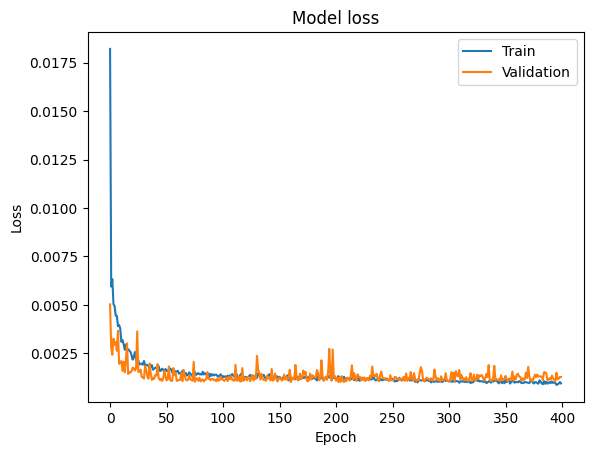

In [209]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [230]:
prediction=Model.predict(testX)
prediction = prediction.reshape((len(prediction),1))
print("prediction\n", )
print("\nPrediction Shape-",prediction.shape)
prediction.shape

4/4 [==============================] - 0s 9ms/step
prediction


Prediction Shape- (124, 1)


(124, 1)

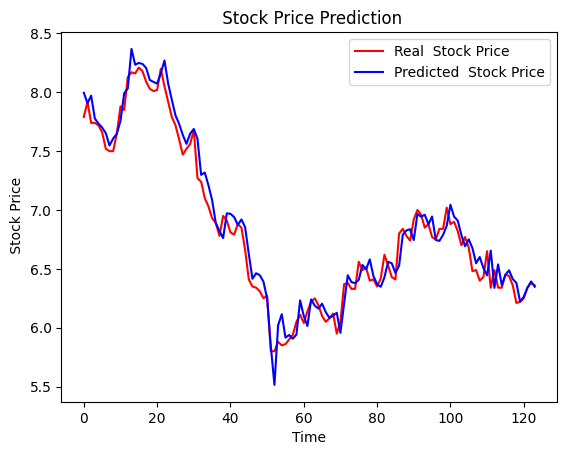

In [231]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)
prediction_copies_array
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

original_copies_array = np.repeat(testY,5, axis=-1)
original_copies_array.shape
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

import matplotlib.pyplot as plt
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [228]:
df

,Open,Close,High,Low,Volume
Date,,,,,
2018-01-02,11.89,11.40,11.90,11.18,178480580
2018-01-03,11.40,11.94,12.10,11.07,196372154
2018-01-04,11.63,11.41,11.72,11.30,164179933
2018-01-05,11.41,11.17,11.61,11.14,128855534
2018-01-08,11.90,11.60,12.13,11.39,318765590
...,...,...,...,...,...
2023-09-08,6.22,6.26,6.28,6.20,15095322
2023-09-11,6.25,6.36,6.38,6.25,26290413
2023-09-12,6.34,6.40,6.48,6.32,28288000


In [202]:
import re
input_string = "12345.zs"
output_string = re.sub(r'(\d+)\.zs', r'SZ.\1', input_string)

print(output_string)

SZ.12345


In [ ]:
r'zs.(\d+)\', r'SZ.\1'